![n7](http://cots.perso.enseeiht.fr/figures/inp-enseeiht.png)

# A one dimensional regulator problem

We consider the following optimal control problem:

$$ 
    \left\{ 
    \begin{array}{l}
        \min \displaystyle J(x, u)  := \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

To this optimal control problem is associated the stationnary optimization problem

$$
    \min_{(x, u)} \{~ x^2 ~ | ~  (x, u) \in \mathrm{R} \times [-1, 1],~ f(x,u) = u = 0\}.
$$

The static solution is thus $(x^*, u^*) = (0, 0)$. This solution may be seen as the static pair $(x, u)$ which minimizes the cost $J(x, u)$ under
the constraint $u \in [-1, 1]$.
It is well known that this problem is what we call a *turnpike* optimal control problem.
Hence, if the final time $t_f$ is long enough the solution is of the following form: 
starting from $x(0)=1$, reach as fast as possible the static solution, stay at the static solution as long as possible before reaching
the target $x(t_f)=1/2$. In this case, the optimal control would be

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f$. We say that the control is *Bang-Singular-Bang*. A Bang arc corresponds to $u \in \{-1, 1\}$ while a singular control corresponds to $u \in (-1, 1)$. Since the optimal control law is discontinuous, then to solve this optimal control problem by indirect shooting methods and find the *switching times* $t_1$ and $t_2$, we need to give the structure to the algorithm. Hence, assuming we do not know the optimal structure, we need an alternative. We thus consider a direct method which consists roughly speaking in a full discretization of the state and control variables on a given time steps grid.

<div class="alert alert-warning">

**Main goals**

1. Retrieve the optimal structure by a direct method.
2. Find the switching times $t_1$ and $t_2$ by indirect shooting.
    
</div>

## Direct method

In [1]:
# For direct methods
#import Pkg;
#Pkg.add("Ipopt");
using JuMP, Ipopt
# To plot solutions
using Plots

In [2]:
# See the following links to get examples:
# https://ct.gitlabpages.inria.fr/gallery/goddard-j/goddard.html
# https://ct.gitlabpages.inria.fr/gallery/turnpike/2d/turnpike.html

# Create JuMP model, using Ipopt as the solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)

#######
####### DEBUT A MODIFIER
#######
####### Les ... sont a remplacer !
#######
####### Attention, on ecrit le probleme sous la forme d'un probleme de Mayer
#######

# Parameters
t0 = 0.    # initial time
tf = 4.    # final time
c0 = 0.    # Initial cost
x0 = 1.    # Initial position
xf = 0.5    # Final position

N  = 500    # Grid size
Δt = (tf-t0)/N  # Time step

@variables(sys, begin
    c[1:N+1]       # Cost
    x[1:N+1]       # Position
    -1 <= u[1:N+1] <= 1       # Control
end)

# Objective
@objective(sys, Min, c[N+1])

# Boundary constraints
@constraints(sys, begin
    con_c0, c[1]-c0 == 0 # constraint on inital cost
    con_x0, x[1]-x0 == 0 # constraint on inital x
    con_xf, x[N+1]-xf == 0 # constraint on final x
end)

@NLexpressions(sys, begin
    dc[j = 1:N+1],  x[j]^2
    dx[j = 1:N+1],  u[j]
end)

# Dynamics with Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_dc[j=1:N], c[j+1] == c[j] + 0.5 * Δt * (dc[j+1] + dc[j]) # differential constraint on the dynamics of the cost
    con_dx[j=1:N], x[j+1] == x[j] + 0.5 * Δt * (dx[j+1] + dx[j]) # differential constraint on the dynamics of the state x
end)

#######
####### FIN A MODIFIER
#######

(NonlinearConstraintRef{ScalarShape}[c[2] - (c[1] + 0.5 * 0.008 * (subexpression[2] + subexpression[1])) = 0, c[3] - (c[2] + 0.5 * 0.008 * (subexpression[3] + subexpression[2])) = 0, c[4] - (c[3] + 0.5 * 0.008 * (subexpression[4] + subexpression[3])) = 0, c[5] - (c[4] + 0.5 * 0.008 * (subexpression[5] + subexpression[4])) = 0, c[6] - (c[5] + 0.5 * 0.008 * (subexpression[6] + subexpression[5])) = 0, c[7] - (c[6] + 0.5 * 0.008 * (subexpression[7] + subexpression[6])) = 0, c[8] - (c[7] + 0.5 * 0.008 * (subexpression[8] + subexpression[7])) = 0, c[9] - (c[8] + 0.5 * 0.008 * (subexpression[9] + subexpression[8])) = 0, c[10] - (c[9] + 0.5 * 0.008 * (subexpression[10] + subexpression[9])) = 0, c[11] - (c[10] + 0.5 * 0.008 * (subexpression[11] + subexpression[10])) = 0  …  c[492] - (c[491] + 0.5 * 0.008 * (subexpression[492] + subexpression[491])) = 0, c[493] - (c[492] + 0.5 * 0.008 * (subexpression[493] + subexpression[492])) = 0, c[494] - (c[493] + 0.5 * 0.008 * (subexpression[494] + subexpr

In [3]:
# Solve for the control and state
println("Solving...")
status = optimize!(sys)
println()

# Display results
if termination_status(sys) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(sys))
println()

# Retrieves values (including duals)
c  = value.(c)[:]
x  = value.(x)[:]
u  = value.(u)[:]
t  = (1:N+1) * value.(Δt)

pc0 = dual(con_c0)
px0 = dual(con_x0)
pxf = dual(con_xf)

if(pc0*dual(con_dc[1])<0); pc0 = -pc0; end
if(px0*dual(con_dx[1])<0); px0 = -px0; end
if(pxf*dual(con_dx[N])<0); pxf = -pxf; end

if (pc0 > 0) # Sign convention according to Pontryagin Maximum Principle
    sign = -1.0
else
    sign =  1.0
end

pc = [ dual(con_dc[i]) for i in 1:N ]
px = [ dual(con_dx[i]) for i in 1:N ]

pc = sign * [pc0; pc[1:N]] 
px = sign * [px0; (px[1:N-1]+px[2:N])/2; pxf]; # We add the multiplier from the limit conditions

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:     1503
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1003
Total number of in

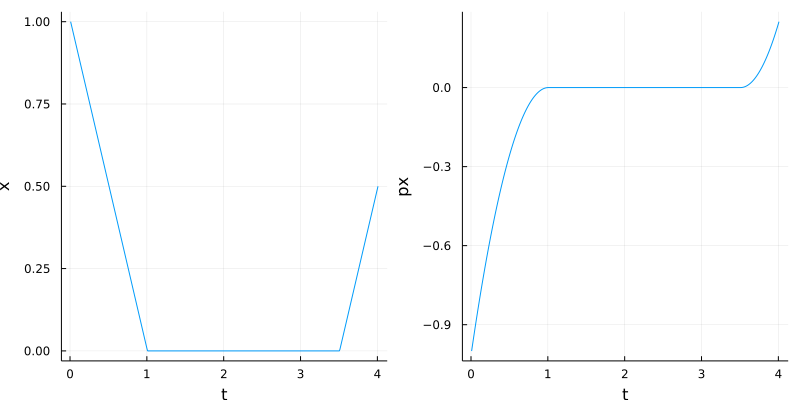

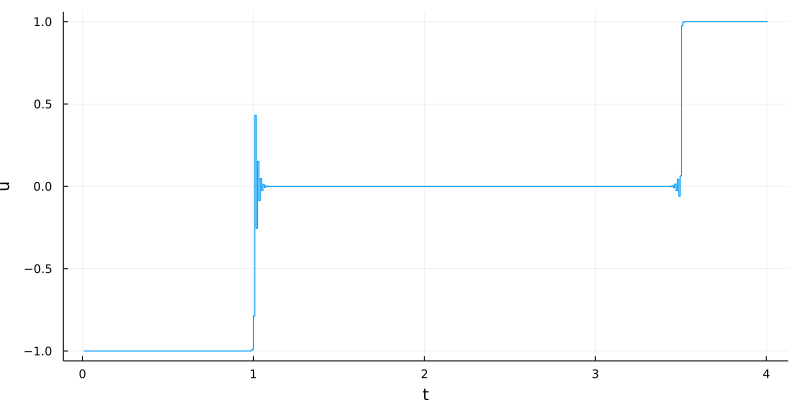

In [4]:
#c_plot = plot(t, c, xlabel = "t", ylabel = "c", legend = false, fmt = :png)
x_plot = plot(t, x, xlabel = "t", ylabel = "x", legend = false, fmt = :png)
u_plot = plot(t, u, xlabel = "t", ylabel = "u", legend = false, fmt = :png, size=(800,400), linetype=:steppre)
#pc_plot = plot(t, pc, xlabel = "t", ylabel = "pc", legend = false, fmt = :png)
px_plot = plot(t, px, xlabel = "t", ylabel = "px", legend = false, fmt = :png)
#display(plot(c_plot, x_plot, pc_plot, px_plot, layout = (2,2), size=(800,400)))
display(plot(x_plot, px_plot, layout = (1,2), size=(800,400)))
display(u_plot)

## Indirect method

In [5]:
# For indirect methods
using DifferentialEquations, NLsolve, ForwardDiff

In [6]:
# Function to get the flow of a Hamiltonian system
function Flow(hv)

    function rhs!(dz, z, dummy, t)
        n = size(z, 1)÷2
        dz[:] = hv(z[1:n], z[n+1:2*n])
    end
    
    function f(tspan, x0, p0; abstol=1e-12, reltol=1e-12, saveat=0.01)
        z0 = [ x0 ; p0 ]
        ode = ODEProblem(rhs!, z0, tspan)
        sol = DifferentialEquations.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, tf; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, tf), x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2*n, end]
    end
    
    return f

end;

The pseudo-Hamiltonian is

$$
    H(x, p, u) = pu - x^2
$$

and the pseudo-Hamiltonian system is

$$
    \vec{H}(x, p, u) = (\partial_p H(x, p, u), -\partial_x H(x, p, u)) = (u, 2x).
$$

The maximizing control is given by

$$
    u(t)~ \left\{~
    \begin{array}{lll}
        = -1            & \text{if} & p(t) < 0,     \\[0.5em]
        \in [-1, 1]     & \text{if} & p(t) = 0,   \\[0.5em]
        = +1            & \text{if} & p(t) > 0,
    \end{array}
    \right. 
$$

A *singular arc* is a part of an extremal such that $p(t) = 0$. Here, we have a singular arc for $t \in [t_1, t_2]$.
On the interval $[t_1, t_2]$, we have $p(t)=0$. Hence, along this arc $\dot{p}(t)=2x(t)=0$. Derivating once again,
we have $\dot{x}(t) = u(t) = 0$. The singular control is thus the null control.

In [7]:
# Pseudo-Hamiltonian system
function hv(x, p, u)
    r = zeros(eltype(x), 2)
    r[1] = u
    r[2] = 2.0*x[1]
    return r
end

hv_min(x, p) = hv(x, p, -1.0)
hv_max(x, p) = hv(x, p,  1.0)
hv_sin(x, p) = hv(x, p,  0.0)

fmin = Flow(hv_min)
fmax = Flow(hv_max)
fsin = Flow(hv_sin);

We have determined that the optimal control follows the strategy:

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f=2$. 

We define the following shooting function:

$$
 S(p_0, t_1, t_2) := 
 \begin{pmatrix}
     x(t_1, t_0, x_0, p_0, u_-) \\
     p(t_1, t_0, x_0, p_0, u_-) \\
     x(t_f, t_2, x_2, p_2, u_+) - 1/2
 \end{pmatrix},
$$

where $z_2 := (x_2, p_2) = z(t_2, t_1, x_1, p_1, u_0)$, $z_1 := (x_1, p_1) = z(t_1, t_0, x_0, p_0, u_-)$ and where z(t, s, a, b, u) is the solution at time $t$ of the Hamiltonian system associated to the control u starting at time $s$ at the initial condition $z(s) = (a,b)$.

We have introduced the notation $u_-$ for $u\equiv -1$, $u_0$ for $u\equiv 0$ and $u_+$ for $u\equiv +1$.

In [8]:
# See the following link to get more details about this problem:
# https://ct.gitlabpages.inria.fr/gallery/shooting_tutorials/multiple_shooting_homotopy.html

#######
####### DEBUT A MODIFIER
#######
####### Les ... sont a remplacer !
#######

# Shooting function
x0 = [x0]
xf = 0.5
t0 = 0.0;
tf = 4.0;

function shoot(p0, t1, t2)
    
    # integration
    x1, p1 = fmin(t0, x0, p0, t1)
    x2, p2 = fsin(t1, x1, p1, t2)
    x3, p3 = fmax(t2, x2, p2, tf)
    
    # conditions
    #s = zeros(eltype(p0[1]), 3)
    #
    #s[1] = x1[1]
    #s[2] = p1[1]
    #s[3] = x3[1] - 0.5
    
    s = [x1[1]; p1[1]; x3[1]-0.5]
    return s

end;

#######
####### FIN A MODIFIER
#######
#######

In [9]:
# Find the initial guess
η = 1e-3
tsin = t[ abs.(px) .≤ η ]

p0 = px[1]
t1 = min(tsin...)
t2 = max(tsin...)
y = [ p0 ; t1 ; t2]

println("Initial guess:\n", y)

Initial guess:
[-1.000013991176403, 0.984, 3.536]


In [10]:
# Jacobian of the shooting function
foo(y) = shoot(y[1], y[2], y[3])
jfoo(y) = ForwardDiff.jacobian(foo, y)

# Solve shoot(p0, t1, t2) = 0.
nl_sol = nlsolve(foo, jfoo, y; xtol=1e-8, method=:trust_region, show_trace=true);

# Retrieves solution
if converged(nl_sol)
    p0 = nl_sol.zero[1]
    t1 = nl_sol.zero[2]
    t2 = nl_sol.zero[3];
    println("\nFinal solution:\n", nl_sol.zero)
else
    error("Not converged")
end

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.000000e-02              NaN
     1     2.560000e-04     3.939617e-02
     2     2.775558e-16     2.560000e-04

Final solution:
[-1.0000000000000018, 1.0000000000000002, 3.4999999999999996]


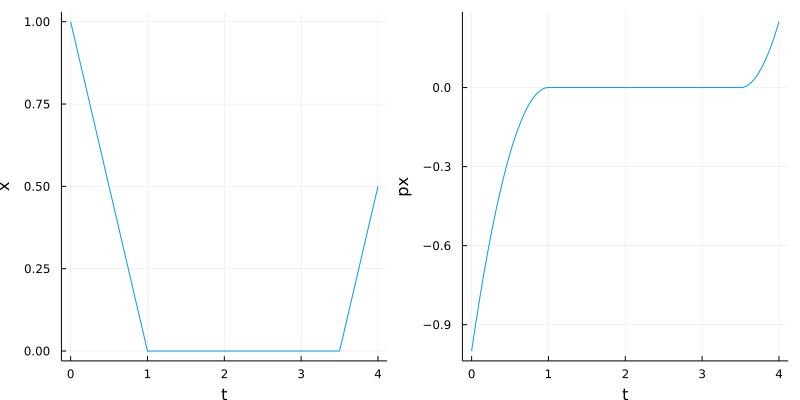

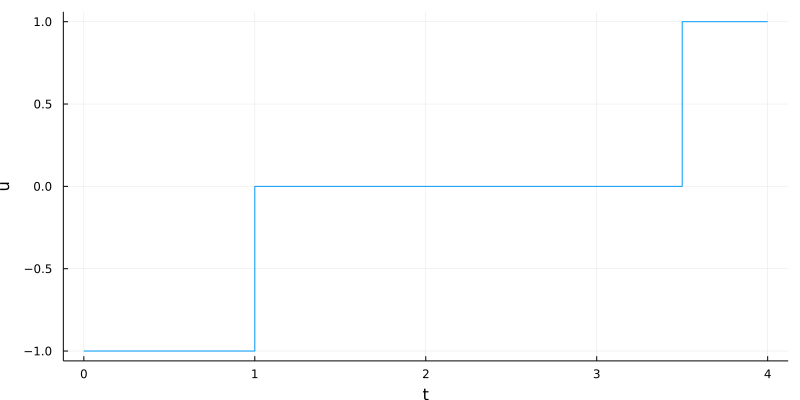

In [11]:
# Plots 
ode_sol = fmin((t0, t1), x0, p0)
tt0 = ode_sol.t
xx0 = [ ode_sol[1, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[2, j] for j in 1:size(tt0, 1) ]
uu0 = -ones(size(tt0, 1))

ode_sol = fsin((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[2, j] for j in 1:size(tt1, 1) ]
uu1 = zeros(size(tt1, 1))

ode_sol = fmax((t2, tf), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[2, j] for j in 1:size(tt2, 1) ]
uu2 = ones(size(tt2, 1))

t_shoot = [ tt0 ; tt1 ; tt2 ]
x_shoot = [ xx0 ; xx1 ; xx2 ]
p_shoot = [ pp0 ; pp1 ; pp2 ]
u_shoot = [ uu0 ; uu1 ; uu2 ]    

x_plot = plot(t_shoot, x_shoot, xlabel = "t", ylabel = "x", legend = false, fmt = :png)
u_plot = plot(t_shoot, u_shoot, xlabel = "t", ylabel = "u", legend = false, fmt = :png, size=(800,400), linetype=:steppre)
px_plot = plot(t_shoot, p_shoot, xlabel = "t", ylabel = "px", legend = false, fmt = :png)
display(plot(x_plot, px_plot, layout = (1,2), size=(800,400)))
display(u_plot)